In [1]:
!pip install matplotlib tensorflow_datasets ipywidgets

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
  print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

#tensorflow dataset api to load the dataset
ds = tfds.load('fashion_mnist', split='train')

In [4]:
#data transformations
import numpy as np

In [5]:
#iterator for dataset
iterator = ds.as_numpy_iterator()

In [6]:
iterator.next() #getting data out of pipeline

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

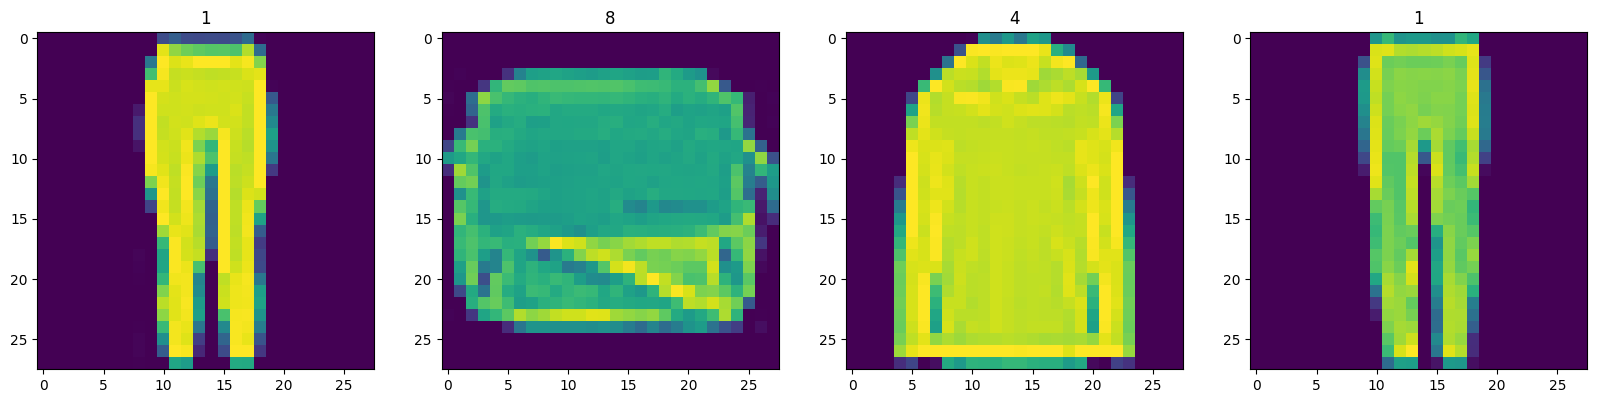

In [7]:
#Setup the subplot formatting
figure, ax = plt.subplots(ncols=4, figsize=(20,20))

#Loop four times and get images
for index in range(4):
    #Grab an image and label
    sample = iterator.next()

    #Plot the image using a specific subplot
    ax[index].imshow(np.squeeze(sample['image']))

    #Appending the image label as the plot title
    ax[index].title.set_text(sample['label'])

In [8]:
#Scale and return images only
def scale_image(data):
    image = data['image']
    return image/255

In [9]:
#Running the dataset through the scale_images preprocssing step
ds = ds.map(scale_image)

#Cache the dataset for that batch
ds = ds.cache()

#Shuffle it up
ds = ds.shuffle(60000)

#batch into 128 images per sample
ds = ds.batch(128)

#Reduce the chance of bottleneck
ds = ds.prefetch(64)

In [10]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [11]:
#Bring sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
#Bring in layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [12]:
def build_generator():
    model = Sequential()

    #Takes in random values and reshapes it to 7x7x128
    model.add(Dense(7*7*128, input_dim = 128))
    model.add(LeakyReLU(0.2))   #Activation function
    model.add(Reshape((7,7,128)))

    #Upsampling layer 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    #Upsampling layer 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    #Convolution layer 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    #Convolution layer 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    #Convolution layer to get one channel
    model.add(Conv2D(1,4,padding='same', activation='sigmoid'))

    return model

In [13]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 7s 7s/step


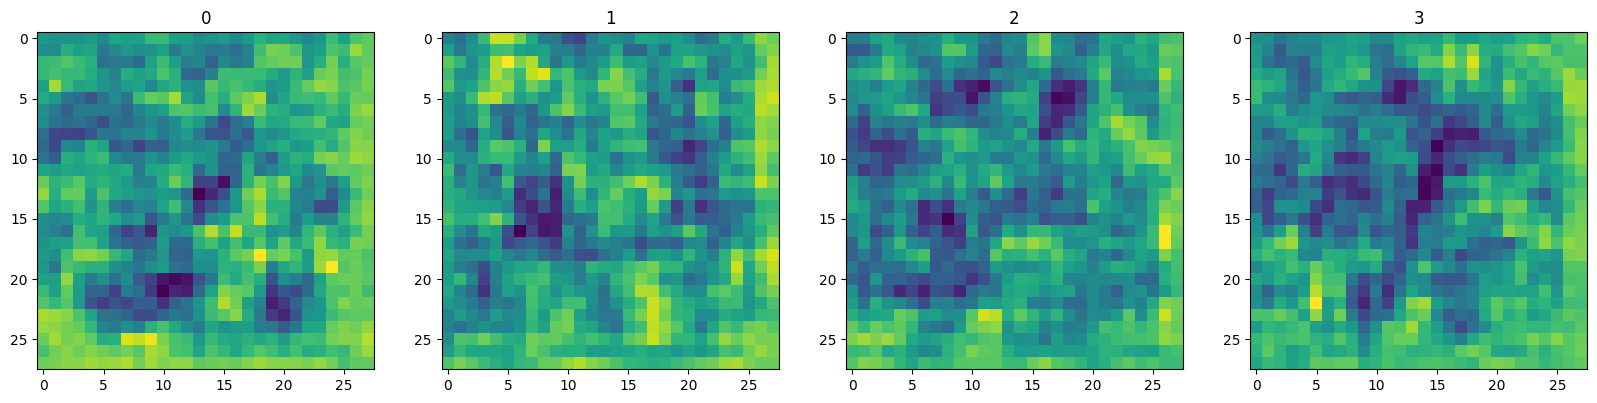

In [14]:
img = generator.predict(np.random.randn(4,128,1))

#Setup the subplot formatting
figure, ax = plt.subplots(ncols=4, figsize=(20,20))

#Loop four times and get images
for index, img in enumerate(img):

    #Plot the image using a specific subplot
    ax[index].imshow(np.squeeze(img))

    #Appending the image label as the plot title
    ax[index].title.set_text(index)

In [15]:
def build_discriminator():
    model = Sequential()

    #First convolution layer
    model.add(Conv2D(32,5,input_shape=(28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #Second Convolution layer
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #Third Convolution layer
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #Fourth Convolution layer
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [16]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [17]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 32ms/step


In [18]:
discriminator.predict(img)

1/1 [==============================] - 0s 266ms/step


array([[0.47568566],
       [0.47591943],
       [0.47616726],
       [0.47625473]], dtype=float32)

# Training loop

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [20]:
gen_opt = Adam(learning_rate=0.0001)
dis_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [21]:
#import base model calss to subclass
from tensorflow.keras.models import Model

In [22]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        #Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        #Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, gen_opt, dis_opt, g_loss, d_loss, *args, **kwargs):
        #Compile with base class
        super().compile(*args, **kwargs)
        self.gen_opt = gen_opt
        self.dis_opt = dis_opt;
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        #Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training = False)

        #Train the discriminator
        with tf.GradientTape() as d_tape:

            #Pass the real and fake images to discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            #Create Labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            #Add some noise to the output
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)


            #Calculate Loss - Binary Cross
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        #Apply backpropagation
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.dis_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        #Train the generator
        with tf.GradientTape() as g_tape:
            #Generate some new image
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training = False)

            #Create the predicted Labels
            predicted_labels = self.discriminator(gen_images, training=False)

            #Calculate loss - trick the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        #Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.gen_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [23]:
fashgan = FashionGAN(generator, discriminator)

In [24]:
fashgan.compile(gen_opt, dis_opt, g_loss, d_loss)

In [25]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [26]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [ ]:
# hist = fashgan.fit(ds, epochs=20000, callbacks=[ModelMonitor()])

Epoch 1/25000
469/469 [==============================] - 138s 281ms/step - d_loss: 0.5337 - g_loss: 0.8211
Epoch 2/25000
469/469 [==============================] - 155s 332ms/step - d_loss: 0.3472 - g_loss: 2.1814
Epoch 3/25000
354/469 [=====================>........] - ETA: 40s - d_loss: 0.2778 - g_loss: 2.6389

In [ ]:
# plt.subtitle('Loss')
# plt.plot(hist.history['d_loss'], label='d_loss')
# plt.plot(hist.history['g_loss'], label='g_loss')
# plt.show()

In [ ]:
generator.load_weights(os.path.join('archive', 'generatormodel.h5'))
# generator.save('generator.h5')
# discriminator.save('discriminator.h5')

In [ ]:
images = generator.predict(tf.random.normal((16, 128, 1)))
fig, ax = plt.subplots(ncols=4, nrols=4, figsize=(20,20))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(images[(r+1)*(c+1)-1])